## Cell Types Database

This notebook demonstrates most of the features of the AllenSDK that help manipulate data in the Cell Types Database.  The main entry point will be through the `CellTypesCache` class.

`CellTypesCache` is responsible for downloading Cell Types Database data to a standard directory structure on your hard drive.  If you use this class, you will not have to keep track of where your data lives, other than a root directory.

In [1]:
from allensdk.core.cell_types_cache import CellTypesCache

# Instantiate the CellTypesCache instance.  The manifest_file argument
# tells it where to store the manifest, which is a JSON file that tracks
# file paths.  If you supply a relative path (like this), it will go
# into your current working directory
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

# this saves the NWB file to 'cell_types/specimen_464212183/ephys.nwb'
data_set = ctc.get_ephys_data(464212183)

The `data_set` variable is an `NwbDataSet` instance, which has some methods we can use to access the injected current stimulus waveform and the voltage response waveform for all experimental sweeps.  Let's pull one sweep out and plot it.

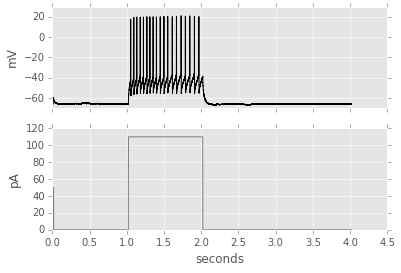

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

sweep_number = 30
sweep_data = data_set.get_sweep(sweep_number)

index_range = sweep_data["index_range"]
i = sweep_data["stimulus"][0:index_range[1]+1] # in A
v = sweep_data["response"][0:index_range[1]+1] # in V
i *= 1e12 # to pA
v *= 1e3 # to mV

sampling_rate = sweep_data["sampling_rate"] # in Hz
t = np.arange(0, len(v)) * (1.0 / sampling_rate)

plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(t, v, color='black')
axes[1].plot(t, i, color='gray')
axes[0].set_ylabel("mV")
axes[1].set_ylabel("pA")
axes[1].set_xlabel("seconds")

## Filtering Cells via Metadata

Cell records in the Cell Types Database come with a large amount of metadata.  We have exposed the most commonly used of these are arguments to CellTypesCache.get_cells.  

In [3]:
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.core.cell_types_cache import ReporterStatus as RS

ctc = CellTypesCache(manifest_file='cell_types/manifest.json', base_uri='http://testwarehouse:9000')

# this downloads metadata for all cells with morphology images
cells = ctc.get_cells(require_morphology = True)
print "Cells with morphology images: ", len(cells)

# cells with reconstructions
cells = ctc.get_cells(require_reconstruction = True)
print "Cells with reconstructions: ", len(cells)

# all cre positive cells
cells = ctc.get_cells(reporter_status = RS.POSITIVE)
print "Cre-positive cells: ", len(cells)

# cre negative cells with reconstructions
cells = ctc.get_cells(require_reconstruction = True, 
                      reporter_status = RS.NEGATIVE)
print "Cre-negative cells with reconstructions: ", len(cells)

Cells with morphology images:  510
Cells with reconstructions:  217
Cre-positive cells:  675
Cre-negative cells with reconstructions:  24


## Cell Morphology Reconstructions

The Cell Types Database also contains 3D reconstructions of neuronal morphologies. The data are presented in the SWC format. We'll download a particular cell's reconstrution here.

The AllenSDK contains a module that makes it easier to work with the SWC files. We'll see how the data is contained in the file by looking at the first node.

In [4]:
# download and open an SWC file
cell_id = 480114344
morphology = ctc.get_reconstruction(cell_id) 

compartment_list = morphology.compartment_list
print compartment_list[0]

{'parent': -1, 'radius': 7.6078, 'y': 503.0168, 'x': 444.3296, 'z': 31.92, 'type': 1, 'id': 0}


Note that the `type` field refers to the type of neuronal compartment. The values can be 1 for the soma, 2 for the axon, 3 for dendrites, and 4 for apical dendrites (if present).

Morphologies now also come with marker files, which contains points of interest in the reconstruction.  The marker file contains locations where dendrites have been truncated due to slicing and when axons were not reconstructed.  The `name` field indicates the type of marker (10 for dendrite truncation, 20 for no reconstruction).

In [5]:
# download and open a marker file
markers = ctc.get_reconstruction_markers(cell_id) 

print markers[0]

{'y': 496.4319, 'x': 527.5029999999999, 'z': 12.4555, 'name': 10}


We can use this data to draw lines between each node and all its children to get a drawing of the cell. We'll do it looking at it from the front and from the side.

/local1/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


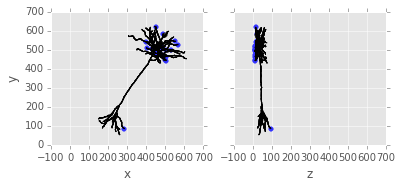

In [6]:
from allensdk.core.swc import Marker
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
axes[0].set_aspect('equal', 'box-forced')
axes[1].set_aspect('equal', 'box-forced')

# Make a line drawing of x-y and y-z views
for n in morphology.compartment_list:
    for c in n.children:
        axes[0].plot([n['x'], c['x']], [n['y'], c['y']], color='black')
        axes[1].plot([n['z'], c['z']], [n['y'], c['y']], color='black')

# cut dendrite markers
dm = [ m for m in markers if m['name'] == Marker.CUT_DENDRITE ]

axes[0].scatter([m['x'] for m in dm], [m['y'] for m in dm], color='#3333ff')
axes[1].scatter([m['z'] for m in dm], [m['y'] for m in dm], color='#3333ff')

# no reconstruction markers
nm = [ m for m in markers if m['name'] == Marker.NO_RECONSTRUCTION ]

axes[0].scatter([m['x'] for m in nm], [m['y'] for m in nm], color='#333333')
axes[1].scatter([m['z'] for m in nm], [m['y'] for m in nm], color='#333333')

axes[0].set_ylabel('y')
axes[0].set_xlabel('x')
axes[1].set_xlabel('z')

## Electrophysiology Features

The Cell Types Database contains a set of features that have already been computed, which could serve as good starting points for analysis. We can query the database using the SDK to get these features.

In [7]:
import pprint
pp = pprint.PrettyPrinter(indent=2)

# download all electrophysiology features for all cells
ephys_features = ctc.get_ephys_features()

# filter down to a specific cell
specimen_id = 464212183
cell_ephys_features = [f for f in ephys_features if f['specimen_id'] == specimen_id]

pp.pprint(cell_ephys_features)

[ { 'adaptation': 0.010660191695700002,
    'avg_isi': 50.9122222222,
    'electrode_0_pa': -73.0906168922,
    'f_i_curve_slope': 0.38701476216499997,
    'fast_trough_t_long_square': 0.22385500000000003,
    'fast_trough_t_ramp': 2.85047,
    'fast_trough_t_short_square': 0.00812666666667,
    'fast_trough_v_long_square': -58.59375,
    'fast_trough_v_ramp': -56.6354192098,
    'fast_trough_v_short_square': -62.052085876499994,
    'has_burst': False,
    'has_delay': False,
    'has_pause': False,
    'id': 464366365,
    'input_resistance_mohm': 129.36264,
    'latency': 30.78,
    'peak_t_long_square': 0.22139,
    'peak_t_ramp': 2.84821,
    'peak_t_short_square': 0.0036491666666699997,
    'peak_v_long_square': 10.71875,
    'peak_v_ramp': 26.4895833333,
    'peak_v_short_square': 16.0000006358,
    'rheobase_sweep_id': 464306919,
    'rheobase_sweep_number': 45,
    'ri': 223.43757404099998,
    'sag': 0.200237980367,
    'seal_gohm': 1.80903808,
    'slow_trough_t_long_square'

That's how to get all the ephys features for a given specimen - what if we want a particular feature for all cells?

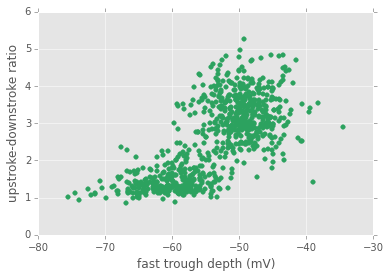

In [8]:
updown = np.array([f['upstroke_downstroke_ratio_long_square'] for f in ephys_features], dtype=float)
fasttrough = np.array([f['fast_trough_v_long_square'] for f in ephys_features], dtype=float)

plt.figure()
plt.scatter(fasttrough, updown, color='#2ca25f')
plt.ylabel("upstroke-downstroke ratio")
plt.xlabel("fast trough depth (mV)")

Let's use numpy to fit a regression line to these data and plot it.

First 5 rows of A:
[[-59.53125381   1.        ]
 [-51.53125      1.        ]
 [-43.96875381   1.        ]
 [-38.25000381   1.        ]
 [-50.375        1.        ]]
m 0.108437886192 c 8.39002615421


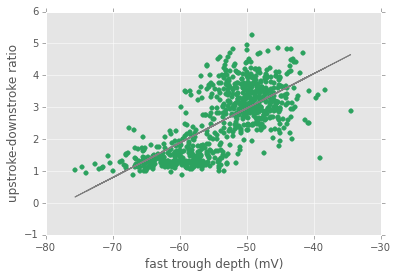

In [9]:
A = np.vstack([fasttrough, np.ones_like(updown)]).T
print "First 5 rows of A:"
print A[:5, :]

m, c = np.linalg.lstsq(A, updown)[0]
print "m", m, "c", c

plt.figure()
plt.scatter(fasttrough, updown, color='#2ca25f')
plt.plot(fasttrough, m * fasttrough + c, c='gray')
plt.ylabel("upstroke-downstroke ratio")
plt.xlabel("fast trough depth (mV)")

It looks like there may be roughly two clusters in the data above. Maybe they relate to whether the cells are presumably excitatory (spiny) cells or inhibitory (aspiny) cells. Let's query the API and split up the two sets to see.

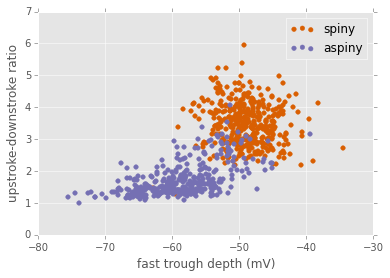

In [10]:
cells = ctc.get_cells()

cell_index = { c['id']: c for c in cells}

dendrite_types = ['spiny', 'aspiny']
data = {}

# group fast trough depth and upstroke downstroke ratio values by cell dendrite type
for dendrite_type in dendrite_types:
    type_features = [f for f in ephys_features if cell_index[f['specimen_id']]['dendrite_type'] == dendrite_type]
    data[dendrite_type] = {
        "fasttrough": [f['fast_trough_v_long_square'] for f in type_features],
        "updown": [f['upstroke_downstroke_ratio_short_square'] for f in type_features],
    }
    
plt.figure()
for a_type, color in zip(dendrite_types, ["#d95f02", "#7570b3"]):
    plt.scatter(data[a_type]['fasttrough'], data[a_type]['updown'], color=color, label=a_type)
plt.legend(loc='best')
plt.ylabel("upstroke-downstroke ratio")
plt.xlabel("fast trough depth (mV)")

## Morphology Features

The Cell Types Database contains a set of precomputed morphological features for cells that have reconstructions.  You can access morphology features by themselves, or combined with the electrophysiology features.

In [11]:
# download all morphology features for cells with reconstructions
morphology_features = ctc.get_morphology_features()

# or download both morphology and ephys features
# this time we'll ask the cache to return a pandas dataframe
all_features = ctc.get_all_features(dataframe=True, require_reconstruction=True)
all_features

,adaptation,avg_isi,electrode_0_pa,f_i_curve_slope,fast_trough_t_long_square,fast_trough_t_ramp,fast_trough_t_short_square,fast_trough_v_long_square,fast_trough_v_ramp,fast_trough_v_short_square,...,overall_depth,overall_height,overall_width,scale_factor_x,scale_factor_y,scale_factor_z,soma_surface,total_length,total_surface,total_volume
0,0.162880,59.473000,5.602500,0.091032,0.048620,5.704792,0.008326,-51.531250,-53.104169,-59.296878,...,573.451370,493.755936,100.580305,0.1144,0.1144,0.28,963.795060,3071.541428,4361.353214,578.994384
1,0.117267,67.903333,-46.703749,0.199413,0.071450,5.513640,0.008346,-50.218750,-52.041668,-56.601564,...,504.739683,308.677120,80.813314,0.1144,0.1144,0.28,371.517864,3122.040442,3811.495256,403.254072
2,0.054231,108.420000,-11.760625,0.201852,0.164395,5.215017,0.008342,-51.531250,-52.114586,-56.331253,...,560.074313,164.071151,91.006056,0.1144,0.1144,0.28,429.486371,1286.255181,1495.093324,151.330010
3,0.158752,81.548000,-40.439999,0.109963,0.095725,2.645368,0.008368,-49.750004,-49.895836,-54.687502,...,634.786109,319.594989,77.711328,0.1144,0.1144,0.28,458.959874,3976.251713,5004.683092,566.911454
4,NaN,64.985000,17.576876,0.074549,0.080415,5.381855,0.008483,-48.468754,-50.802086,-56.062503,...,556.697329,265.179942,106.203603,0.1144,0.1144,0.28,1029.157900,4537.213322,5175.812742,549.894763
5,NaN,6.680000,-77.923744,1.057234,0.010860,NaN,0.008176,-65.218758,NaN,-69.325003,...,404.460034,426.605371,48.425321,0.1144,0.1144,0.28,563.901991,2066.426541,2266.311212,224.042081
6,0.032048,63.995357,17.658123,0.170000,0.108430,4.455838,0.008447,-50.718750,-50.937503,-54.239587,...,342.716999,200.716220,120.924534,0.1144,0.1144,0.28,336.298759,2056.461755,1745.563174,184.193730
7,0.005915,15.761354,18.873125,0.993937,0.014270,12.592923,0.008340,-60.750000,-58.177085,-69.050002,...,312.260922,243.024695,131.073064,0.1144,0.1144,0.28,431.907307,1652.869183,2423.809357,391.219210
8,0.061133,127.561429,-17.731875,0.147616,0.118295,6.542697,0.008416,-42.968754,-45.718751,-51.925002,...,677.075672,299.239901,163.693524,0.1144,0.1144,0.28,607.942584,6138.726392,7192.361640,766.856568
9,0.012376,51.880000,-41.306875,0.290180,0.114295,1.938403,0.008104,-48.531254,-49.406252,-54.981252,...,661.411523,372.200701,143.330853,0.1144,0.1144,0.28,491.793583,2861.680772,5324.046113,1031.358662


## Computing Electrophysiology Features

The AllenSDK contains the code used to compute the electrophysiology features you accessed above.  You can run it yourself like this.

In [12]:
from allensdk.ephys.feature_extractor import EphysFeatureExtractor

sweep_number = 35
sweep_data = data_set.get_sweep(sweep_number)

index_range = sweep_data["index_range"]
i = sweep_data["stimulus"][0:index_range[1]+1] # in A
v = sweep_data["response"][0:index_range[1]+1] # in V
i *= 1e12 # to pA
v *= 1e3 # to mV

sampling_rate = sweep_data["sampling_rate"] # in Hz
t = np.arange(0, len(v)) * (1.0 / sampling_rate)

fx = EphysFeatureExtractor()

stim_start = 1.0
stim_duration = 1.0

fx.process_instance("", v, i, t, stim_start, stim_duration, "")
feature_data = fx.feature_list[0].mean
print "Avg spike width: {:.2f} ms".format(feature_data['width'])
print "Avg spike threshold: {:.1f} mV".format(feature_data["threshold"])

Avg spike width: 0.93 ms
Avg spike threshold: -35.6 mV


In [13]:
import pprint
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(feature_data["spikes"][0])

{ 'downstroke': -114.5881505524148,
  'downstroke_i': 210.0,
  'downstroke_idx': 205802,
  'downstroke_t': 1.02901,
  'downstroke_v': -7.9375005,
  'f_fast_ahp': -55.5,
  'f_fast_ahp_i': 210.0,
  'f_fast_ahp_t': 1.0306000000000002,
  'f_fast_ahp_v': -55.5,
  'f_peak': 18.15625,
  'f_peak_i': 210.0,
  'f_peak_t': 1.02868,
  'f_slow_ahp': -49.8125,
  'f_slow_ahp_t': 1.0336800000000002,
  'f_slow_ahp_time': 0.40799673602611697,
  'f_trough': -55.5,
  'half_height_width': 0.00059500000000012321,
  'peak_idx': 205736,
  'rise_time': 0.00055999999999989392,
  't': 1.0281100000000001,
  't_idx': 205622,
  't_idx_n30': 205666,
  't_n30': 1.0283300000000002,
  'thresh_ramp': 60.584553175236103,
  'threshold': -40.781254,
  'threshold_i': 210.0,
  'threshold_idx': 205622,
  'threshold_t': 1.0281100000000001,
  'threshold_v': -40.781254,
  'trough_i': 210.0,
  'trough_idx': 206120,
  'trough_t': 1.0306000000000002,
  'trough_v': -55.5,
  'upstroke': 216.04000847544683,
  'upstroke_i': 210.0,
  'u

A list comprehension is an easy way to pull out the spike times.

In [14]:
spike_times = [s["t"] for s in feature_data["spikes"]]

print spike_times[:5] 

[1.0281100000000001, 1.0409350000000002, 1.0536750000000001, 1.0686450000000001, 1.082835]


(0.9, 1.2)

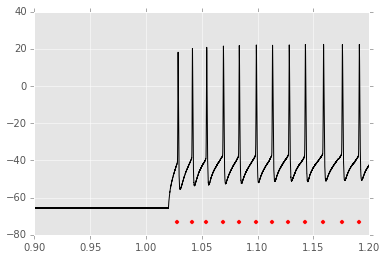

In [15]:
plt.figure()
plt.plot(t, v, color='black')

min_v = v.min()

min_v -= 5.0

plt.scatter(spike_times, np.ones(len(spike_times)) * min_v, c='r')
plt.xlim(0.9, 1.2)